### Histogram Analysis of Model Prediction Activation Values
This notebook demonstrates how one might employ density estimators to identify optimal prediction thresholds for neural network classifiers. Because output layer activations cannot be interpreted as strict probabilities, it is challenging to enforce meaningful thresholds on classification. The approach here uses histogram analysis and density estimators to identify relative values where the distribution of activation values appears to suggest multiple underlying distributions, ie the presence of a positive and negative class. This technique can be valuable with scarce training data when avoidance of false-positives is low-priority but existence of false-negatives is undesirable. While there do not exist enough examples for a classifier to generate clearly-separable prediction values for a class, we can at least infer a lower prediction threshold to maximize coverage.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import brentq
from sklearn.neighbors import KernelDensity
import dill
import math
from sklearn.metrics import label_ranking_average_precision_score

In [2]:
df = pd.read_csv('res/bbc.csv')

In [3]:
topics = df.label.unique().tolist()

In [4]:
topics

['business', 'entertainment', 'politics', 'sport', 'tech']

In [5]:
X = df.text.apply(lambda x: x[:450]).tolist()

In [99]:
y = df.label.apply(lambda x: [1 if l == x else 0 for l in topics]).tolist()

In [75]:
with open('res/bbc.dill', 'rb') as f:
    model = dill.load(f)

In [76]:
predictions, raw_outputs = model.predict(X)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [77]:
activations = []
names = []
truth = []

In [78]:
# organize all the activation values
for i in range(len(X)):
    for activation, label, prediction in zip(raw_outputs[i], topics, predictions[i]):
        activations.append(activation)
        names.append(label)
        truth.append(prediction == 1)

In [79]:
activations, names, truth = np.array(activations), np.array(names), np.array(truth)

In [80]:
suggested_thresholds = []

C:\Users\Jannik\anaconda3\envs\christian\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jannik\anaconda3\envs\christian\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jannik\anaconda3\envs\christian\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

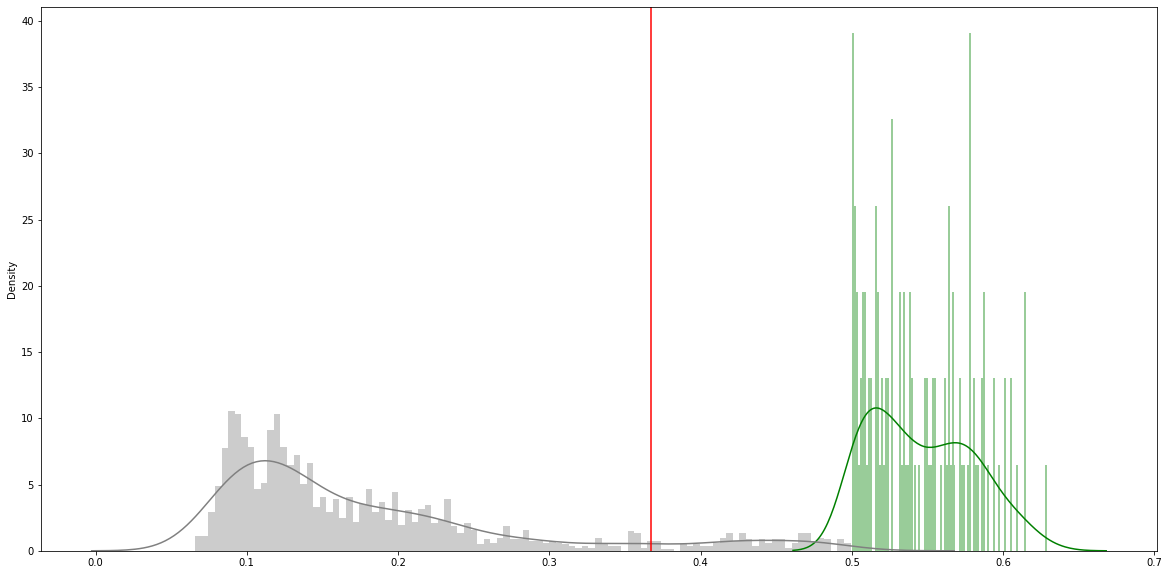

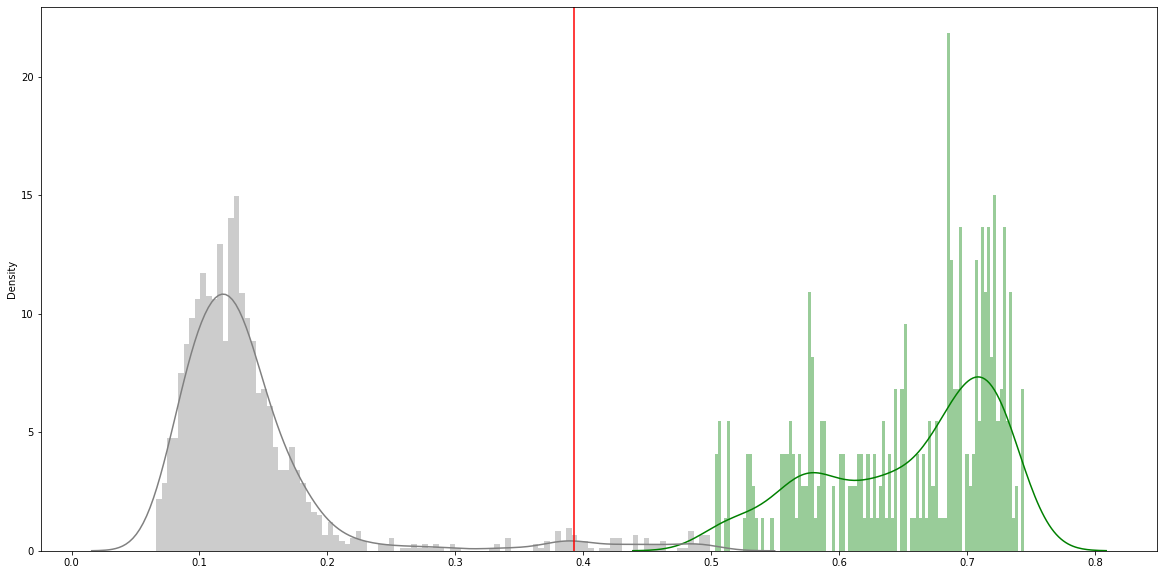

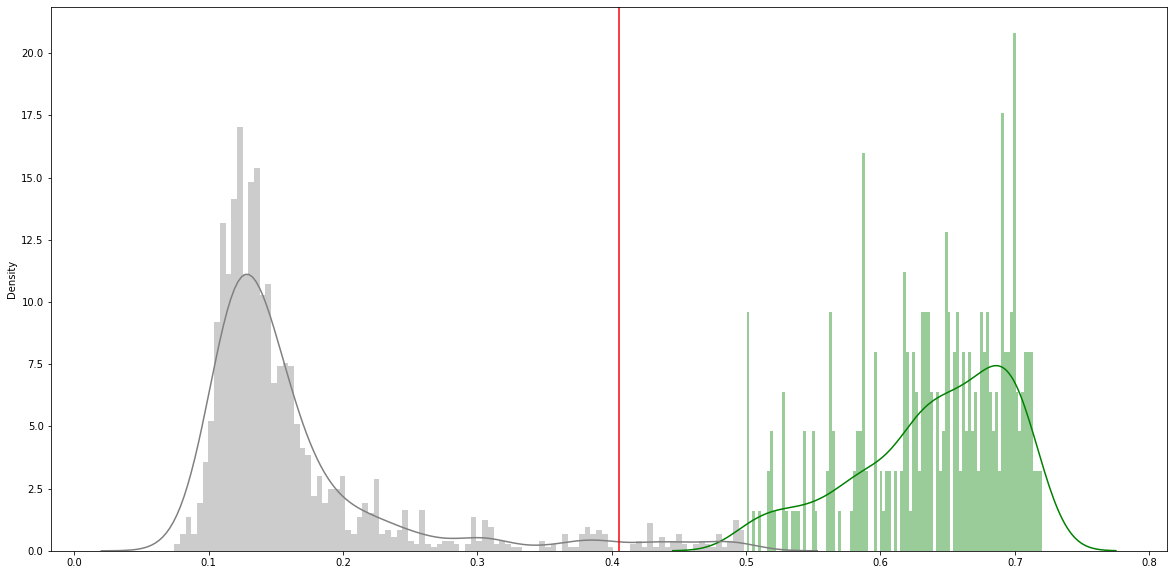

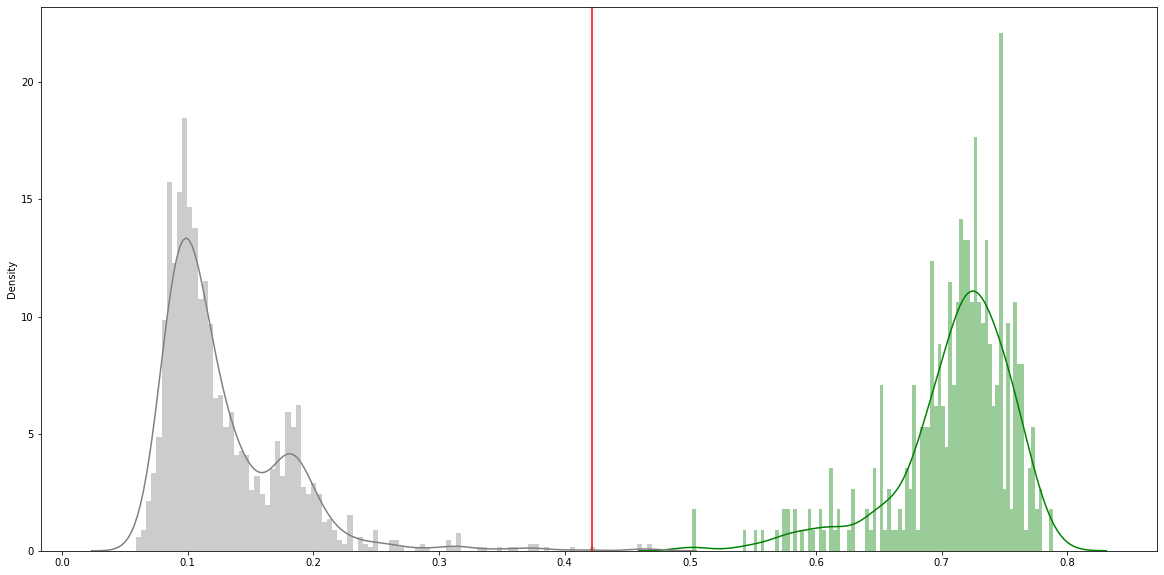

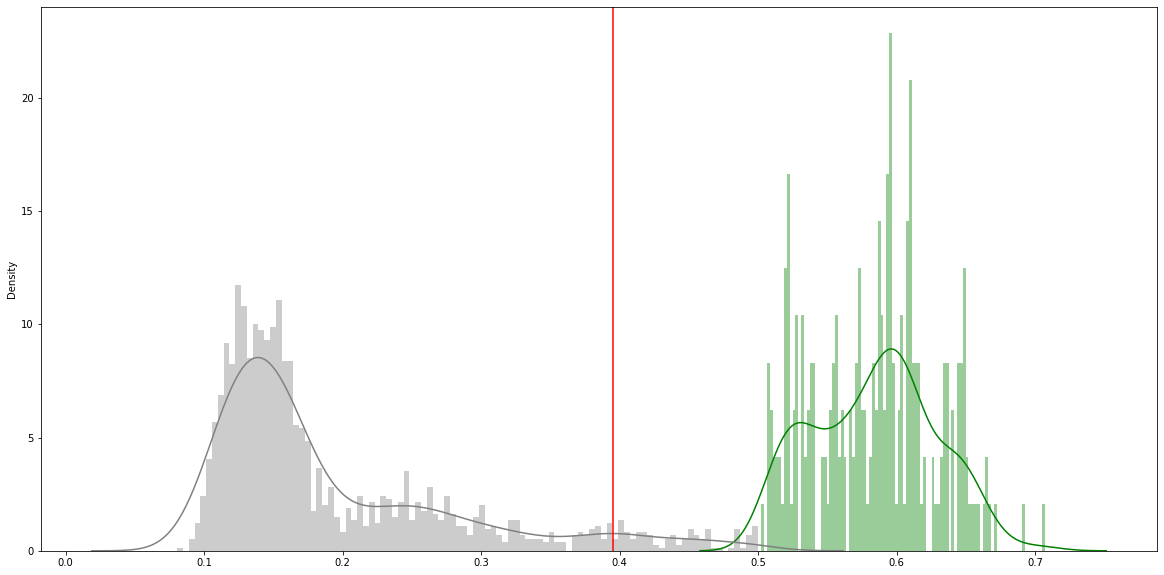

In [81]:
for t in topics:
    plt.figure(figsize=(20,10))
    a_samples = activations[np.where((names==t) & (truth==1))]
    b_samples = activations[np.where((names==t) & (truth==0))]
    try:
        a_kde = sns.distplot(
            a_samples.flatten(), 
            bins=100, 
            label=t+' T', 
            color='green'
        ).get_lines()[-1].get_data()
        b_kde = sns.distplot(
            b_samples.flatten(), 
            bins=100, 
            label=t+' F', 
            color='gray'
        ).get_lines()[-1].get_data()
        xlim = plt.gca().get_xlim()
        kdeA = KernelDensity(kernel='gaussian', bandwidth=.1).fit(a_samples.reshape(-1, 1))
        kdeB = KernelDensity(kernel='gaussian', bandwidth=.1).fit(b_samples.reshape(-1, 1))
        funcA = lambda x: np.exp(kdeA.score_samples(np.array(x).reshape(1, -1)))
        funcB = lambda x: np.exp(kdeB.score_samples(np.array(x).reshape(1, -1)))
        result = brentq(lambda x: funcA(x) - funcB(x), xlim[0], xlim[1])
        
    except Exception:
        sns.distplot(a_samples.flatten(), bins=100, label=t+' T', color='green')
        sns.distplot(b_samples.flatten(), bins=100, label=t+' F', color='gray')
        result = 0.5
        
    plt.axvline(result, color='red')
    suggested_thresholds.append(result)

In [82]:
# apply thresholds to raw_outputs
updated_outputs = []
for output in raw_outputs:
    activations = []
    for i, value in enumerate(output):
        if value > suggested_thresholds[i]:
            activations.append(1)
        else:
            activations.append(0)
            
    updated_outputs.append(activations)

In [101]:
label_ranking_average_precision_score(y, predictions)

0.7312000000000053

In [102]:
label_ranking_average_precision_score(y, updated_outputs)

0.8764000000000032

This method improves prediction accuracy by intelligently lowering the prediction threshold without the need for additional training data.